In [4]:
from pyspark.sql import SparkSession
import calendar
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, to_date, year, month, dayofmonth, round, mean, count, sum, when,first,dayofmonth,day,weekofyear as week
spark = SparkSession.builder.appName("CSV_Loader").getOrCreate()

In [2]:
df = spark.read.csv("../Data/Umsatzdaten/steak_orders.csv", inferSchema=True, header=True)
df = df.drop("_c0")

df = df.withColumn("date", to_date(col("date"), "YYYY-MM-dd"))
df.show()

+----------------+-----+--------+-------------------+-----+----------+-----+------+
|         article|count|   group|             family|price|      date|shift|sector|
+----------------+-----+--------+-------------------+-----+----------+-----+------+
|        RUMP 250|    1| SPEISEN|  STEAKS & BEILAGEN| 22.5|2022-02-01| None|  None|
|      ALSTER 0,3|    1|GETRÄNKE|      BIER/ALK FREI|  3.5|2022-02-01| None|  None|
|SELTERS SIL.0,25|    1|GETRÄNKE|      BIER/ALK FREI|  2.9|2022-02-01| None|  None|
|   HÄHNCHENBRUST|    1| SPEISEN|  STEAKS & BEILAGEN| 18.9|2022-02-01| None|  None|
|  Bratkartoffeln|    1| SPEISEN|  STEAKS & BEILAGEN|  5.5|2022-02-01| None|  None|
|       SCHNITZEL|    1| SPEISEN|AUSGEWÄHLTE SPEISEN| 16.9|2022-02-01| None|  None|
|       SCHNITZEL|    1| SPEISEN|AUSGEWÄHLTE SPEISEN| 16.9|2022-02-01| None|  None|
|       SCHNITZEL|    1| SPEISEN|AUSGEWÄHLTE SPEISEN| 16.9|2022-02-01| None|  None|
|         ASS 0,2|    2|GETRÄNKE|      BIER/ALK FREI|  2.0|2022-02-01| None|

In [3]:
print('df.count  :', df.count())
print('df.col ct :', len(df.columns))
print('df.columns:', df.columns)
print('df.dtypes:', df.dtypes)

df.count  : 114580
df.col ct : 8
df.columns: ['article', 'count', 'group', 'family', 'price', 'date', 'shift', 'sector']
df.dtypes: [('article', 'string'), ('count', 'int'), ('group', 'string'), ('family', 'string'), ('price', 'double'), ('date', 'date'), ('shift', 'string'), ('sector', 'string')]


In [4]:
df = df.withColumn("year", year("date"))
df = df.withColumn("day", day("date"))
df = df.withColumn("month", month("date"))
df = df.withColumn("week", week("date"))
df = df.withColumn("dayofmonth", dayofmonth("date"))  
df.show(3)

+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+
|         article|count|   group|           family|price|      date|shift|sector|year|day|month|week|dayofmonth|
+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+
|        RUMP 250|    1| SPEISEN|STEAKS & BEILAGEN| 22.5|2022-02-01| None|  None|2022|  1|    2|   5|         1|
|      ALSTER 0,3|    1|GETRÄNKE|    BIER/ALK FREI|  3.5|2022-02-01| None|  None|2022|  1|    2|   5|         1|
|SELTERS SIL.0,25|    1|GETRÄNKE|    BIER/ALK FREI|  2.9|2022-02-01| None|  None|2022|  1|    2|   5|         1|
+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+
only showing top 3 rows



In [5]:
# Jahreszeiten zuordnen
df = df.withColumn("season",
                   when(col("month").isin(3, 4, 5), "Frühling")
                   .when(col("month").isin(6, 7, 8), "Sommer")
                   .when(col("month").isin(9, 10, 11), "Herbst")
                   .when(col("month").isin(12, 1, 2), "Winter")
                   .otherwise("Unknown"))
df.show(3)

+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+------+
|         article|count|   group|           family|price|      date|shift|sector|year|day|month|week|dayofmonth|season|
+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+------+
|        RUMP 250|    1| SPEISEN|STEAKS & BEILAGEN| 22.5|2022-02-01| None|  None|2022|  1|    2|   5|         1|Winter|
|      ALSTER 0,3|    1|GETRÄNKE|    BIER/ALK FREI|  3.5|2022-02-01| None|  None|2022|  1|    2|   5|         1|Winter|
|SELTERS SIL.0,25|    1|GETRÄNKE|    BIER/ALK FREI|  2.9|2022-02-01| None|  None|2022|  1|    2|   5|         1|Winter|
+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+------+
only showing top 3 rows



In [6]:
df_ = df.sort(df["week"].desc())
df_.show()

+--------------+-----+--------+-------------------+-----+----------+-----------+-------+----+---+-----+----+----------+------+
|       article|count|   group|             family|price|      date|      shift| sector|year|day|month|week|dayofmonth|season|
+--------------+-----+--------+-------------------+-----+----------+-----------+-------+----+---+-----+----+----------+------+
|       ASS 0,4|    0|GETRÄNKE|      BIER/ALK FREI|  4.0|2022-01-02|Frühschicht|Service|2022|  2|    1|  52|         2|Winter|
|  SELTERS 0,25|    1|GETRÄNKE|      BIER/ALK FREI|  2.9|2022-01-02|Frühschicht|Service|2022|  2|    1|  52|         2|Winter|
|     ZERO  0,4|    2|GETRÄNKE|      BIER/ALK FREI|  4.0|2022-01-02|Frühschicht|Service|2022|  2|    1|  52|         2|Winter|
|    KRAFTBRÜHE|    1| SPEISEN|      VOR/SUP/SALAT|  5.7|2022-01-02|Frühschicht|Service|2022|  2|    1|  52|         2|Winter|
| HÄHNCHENBRUST|    1| SPEISEN|  STEAKS & BEILAGEN| 18.9|2022-01-02|Frühschicht|Service|2022|  2|    1|  52|   

## Basic Analytics

In [7]:
grouped_df = df.groupBy("date").agg(round(sum("price"), 2).alias("total_price"))
grouped_df_d = grouped_df.sort("date")
grouped_df_d.show()

+----------+-----------+
|      date|total_price|
+----------+-----------+
|2022-01-02|     2476.0|
|2022-01-03|     2493.2|
|2022-01-04|     4589.8|
|2022-01-05|     5570.5|
|2022-01-06|     2571.0|
|2022-01-07|     6351.1|
|2022-01-08|     5409.9|
|2022-01-13|     1332.2|
|2022-01-14|     1663.7|
|2022-01-15|     3509.8|
|2022-01-16|     3851.1|
|2022-01-18|     1538.9|
|2022-01-19|     1493.2|
|2022-01-20|     1232.8|
|2022-01-21|     2278.5|
|2022-01-22|     3644.7|
|2022-01-23|     3795.8|
|2022-01-24|    2138.95|
|2022-01-25|     1973.6|
|2022-01-26|    1828.15|
+----------+-----------+
only showing top 20 rows



In [8]:
# Sort by total_price in descending order
grouped_df = grouped_df.sort(grouped_df["total_price"].desc())
grouped_df.show(3)

+----------+-----------+
|      date|total_price|
+----------+-----------+
|2022-08-05|    17073.8|
|2022-07-17|   11775.15|
|2022-03-27|    11750.8|
+----------+-----------+
only showing top 3 rows



In [10]:
grouped_df3 = grouped_df.where(grouped_df['total_price'].between('0','5000'))
grouped_df2 = grouped_df.where(grouped_df['total_price'].between('5000','10000'))
grouped_df3 = grouped_df.where(grouped_df['total_price'].between('10000','15000'))
grouped_df4 = grouped_df.where(grouped_df['total_price'].between('15000','20000'))


print("Umsatz 0-5000: ", grouped_df.count())
print("Umsatz 5000-10000: ", grouped_df2.count())
print("Umsatz 10000-15000: ", grouped_df3.count())
print("Umsatz 15000-20000: ", grouped_df4.count())

Umsatz 0-5000:  234
Umsatz 5000-10000:  91
Umsatz 10000-15000:  9
Umsatz 15000-20000:  1


In [9]:
grouped_df_w = df.groupBy("week").agg(count("*").alias("count_per_week")).orderBy("week")
grouped_df_w = grouped_df_w.sort(grouped_df_w["count_per_week"])
grouped_df_w.show()

+----+--------------+
|week|count_per_week|
+----+--------------+
|  52|           254|
|  39|           393|
|   2|          1049|
|  45|          1198|
|   3|          1377|
|  35|          1515|
|  48|          1757|
|  19|          1876|
|  13|          1978|
|  23|          2002|
|  10|          2027|
|   6|          2047|
|   4|          2168|
|  36|          2184|
|  32|          2208|
|  34|          2250|
|   9|          2294|
|  14|          2359|
|  44|          2400|
|   7|          2469|
+----+--------------+
only showing top 20 rows



In [11]:
grouped_df = df.groupBy("month").agg(round(sum("price"), 2).alias("total_price"))
grouped_df_m = grouped_df.sort(grouped_df["total_price"].desc())
grouped_df_m.show()

+-----+-----------+
|month|total_price|
+-----+-----------+
|    7|  163086.91|
|    6|  152888.68|
|    5|  149158.74|
|    8|   142271.4|
|    4|  132765.94|
|    3|  113375.95|
|    2|  101484.87|
|    1|    76752.6|
|   12|   44099.35|
|    9|    38668.2|
|   10|   38486.05|
|   11|   36806.45|
+-----+-----------+



In [12]:
grouped_df = df.groupBy("season").agg(round(sum("price"), 2).alias("total_price"))
grouped_df = grouped_df.sort(grouped_df["total_price"].desc())
grouped_df.show()

+--------+-----------+
|  season|total_price|
+--------+-----------+
|  Sommer|  458246.99|
|Frühling|  395300.63|
|  Winter|  222336.82|
|  Herbst|   113960.7|
+--------+-----------+



## Visualsisierung 

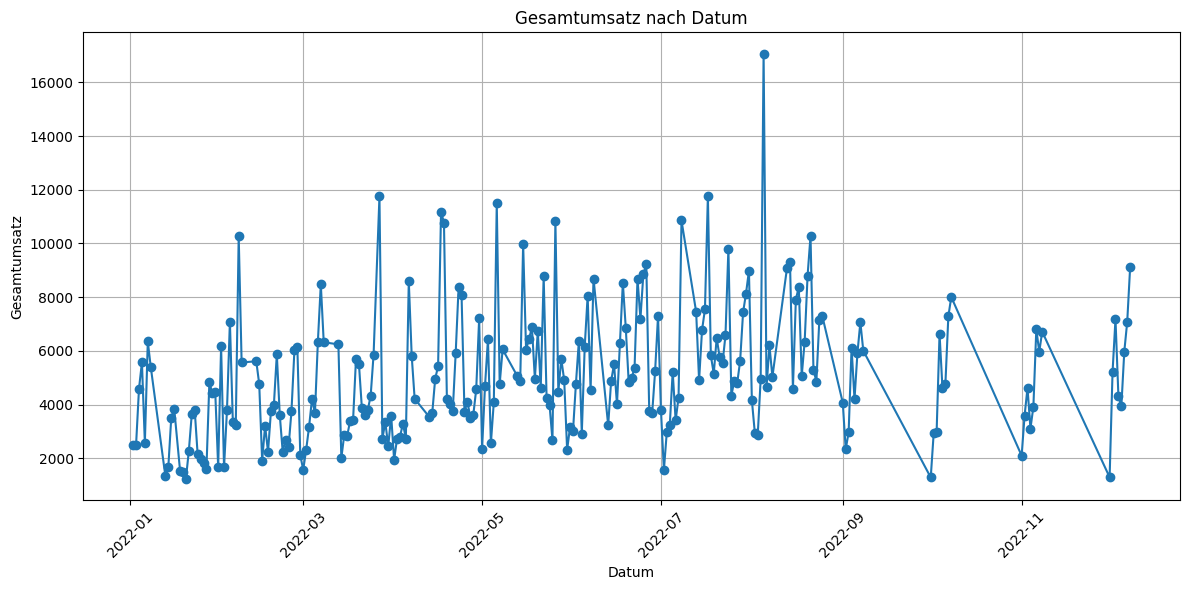

In [21]:
pandas_df = grouped_df_d.toPandas()

pandas_df['date'] = pd.to_datetime(pandas_df['date'])

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['date'], pandas_df['total_price'], marker='o', linestyle='-')
plt.title('Gesamtumsatz nach Datum')
plt.xlabel('Datum')
plt.ylabel('Gesamtumsatz')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/x6/2n7zgvqn5f97hpgxds31xvzm0000gn/T/ipykernel_18385/4265914881.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


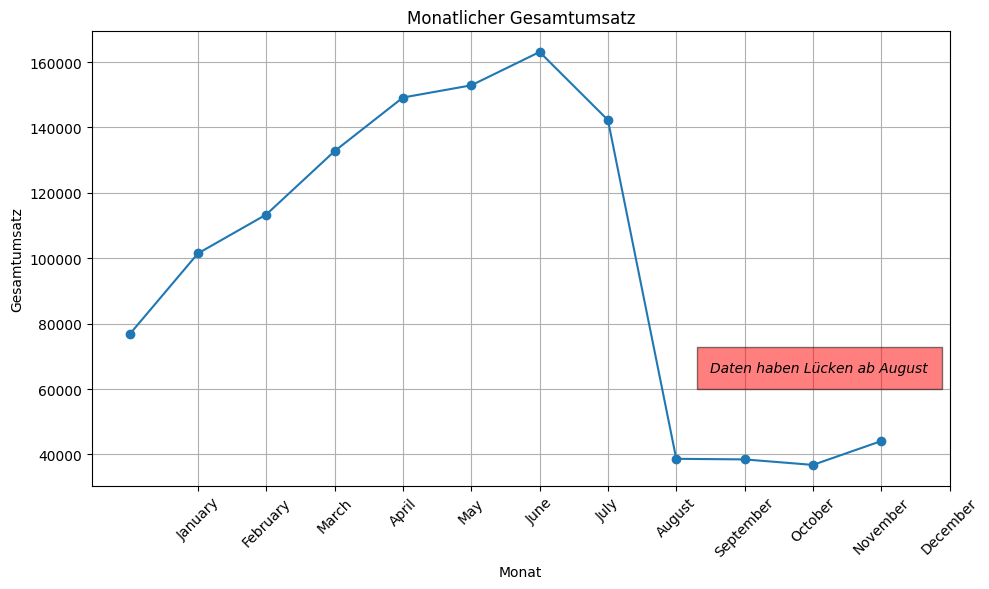

In [20]:
pandas_df = grouped_df_m.toPandas()

plt.figure(figsize=(10, 6))
plt.plot([pandas_df[pandas_df['month'] == m]['total_price'] for m in range(1, 13)],marker='o', linestyle='-')
plt.xticks(range(1, 13), calendar.month_name[1:13], rotation=45)
plt.title('Monatlicher Gesamtumsatz')
plt.xlabel('Monat')
plt.ylabel('Gesamtumsatz')
plt.grid(True)
plt.tight_layout()

plt.text(8.5, max(pandas_df['total_price']) * 0.4, 'Daten haben Lücken ab August', fontsize=10, style='italic',
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

plt.tight_layout()
plt.show()


## Machine Learning

In [15]:
df.show(3)

+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+------+
|         article|count|   group|           family|price|      date|shift|sector|year|day|month|week|dayofmonth|season|
+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+------+
|        RUMP 250|    1| SPEISEN|STEAKS & BEILAGEN| 22.5|2022-02-01| None|  None|2022|  1|    2|   5|         1|Winter|
|      ALSTER 0,3|    1|GETRÄNKE|    BIER/ALK FREI|  3.5|2022-02-01| None|  None|2022|  1|    2|   5|         1|Winter|
|SELTERS SIL.0,25|    1|GETRÄNKE|    BIER/ALK FREI|  2.9|2022-02-01| None|  None|2022|  1|    2|   5|         1|Winter|
+----------------+-----+--------+-----------------+-----+----------+-----+------+----+---+-----+----+----------+------+
only showing top 3 rows



In [16]:
ml_df = df.groupBy("month") \
              .agg(
                  round(sum("price"), 2).alias("total_price"),
                  first("year").alias("year"),
                  first("season").alias("season")
              )

ml_df.toPandas()

,month,total_price,year,season
0,1,76752.60,2022,Winter
1,2,101484.87,2022,Winter
2,3,113375.95,2022,Frühling
3,4,132765.94,2022,Frühling
4,5,149158.74,2022,Frühling
5,6,152888.68,2022,Sommer
6,7,163086.91,2022,Sommer
7,8,142271.40,2022,Sommer
8,9,38668.20,2022,Herbst
9,10,38486.05,2022,Herbst


In [ ]:
# First, index the 'season' column
indexer = StringIndexer(inputCol='season', outputCol='season_index')
indexed_df = indexer.fit(ml_df).transform(ml_df)

# Features
va = VectorAssembler(inputCols=['year', 'month', 'season_index','season','dayofmonth', 'week'], outputCol='features')
df_ml = va.transform(indexed_df).select('features', 'total_price')

df_ml.toPandas()

In [ ]:
(train, test) = df_ml.randomSplit([0.8, 0.2])

In [ ]:
reg = GBTRegressor(featuresCol='features', labelCol='total_price')
model = reg.fit(train)

# Predictions
predictions = model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="total_price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

24/06/18 16:42:01 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 7 (= number of training instances)


Root Mean Squared Error (RMSE) on test data = 13493


24/06/18 16:42:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
